# Pytorch Model 

this notebook will demonstrate the same techniques and practices used in Emotion_Classifier notebook but using Pytorch instead of Tensorflow. Pytorch comes with enough tools that we don't need Librosa as well and Pytorch's audio module "Torchaudio" has audio tranformers that are based on Librosa's fundementals. Then biggest difference might be that Pytorch will turn an audiofile into a Tensor instead of a Numpy array like with Librosa. 

In [1]:
# Importing Necessary Libraries 
# https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html
# Standard Python Operations 
import pandas as pd 
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Audio and torch data
from scipy import signal 
import librosa 
import torchaudio 
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from IPython.display import Audio



# Neural Network 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import sys 

from tqdm import tqdm

torch.manual_seed(0)



# Preparing data 
First the data will be prepared the same way as in my other notebooks. A Pandas Dataframe will be created that contains the Path of the audio file and its respected class label for each observation. Then I will create a custom Data Class object using Pytorch's Data Class

In [2]:
class RavdessDataset(Dataset):

    def __init__(self,
                 annotations_file,
                 audio_dir,
                 
                 target_sample_rate,
                 num_samples,
                 device, 
                 transformation=None):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)

        # if there is any transform method, apply it to audio tensor
        if self.transformation:
            signal = self.transformation(signal).to(self.device)
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def _get_audio_sample_path(self, index):
        fold = f"fold{self.annotations.iloc[index, 5]}"
        path = os.path.join(self.audio_dir, fold, self.annotations.iloc[
            index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 3]


if __name__ == "__main__":
    ANNOTATIONS_FILE = "/Users/stephen/Emotion_Detection-/data/metadata.csv"
    AUDIO_DIR = "/Users/stephen/Emotion_Detection-/data/RAVDESS"
    SAMPLE_RATE = 16000
    NUM_SAMPLES = 16000*4

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device {device}")

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    

    rav = RavdessDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device, 
                            transformation=None,)
    print(f"There are {len(rav)} samples in the dataset.")
    signal, label = rav[0]

Using device cpu
There are 1380 samples in the dataset.


# Pytorch Functions 
Taken directly from the Pytorch documentation and tutorials, we'll define some functions to easily visualize the data. 
https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html

In [3]:
# helper functions 

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

# Visualize data

In [4]:
test_sample, test_label = rav[60]
print(test_label)

fearful


In [5]:
print_stats(test_sample)

Shape: (1, 64000)
Dtype: torch.float32
 - Max:      0.138
 - Min:     -0.124
 - Mean:     0.000
 - Std Dev:  0.014

tensor([[ 2.7397e-07, -6.5228e-07,  1.4276e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])



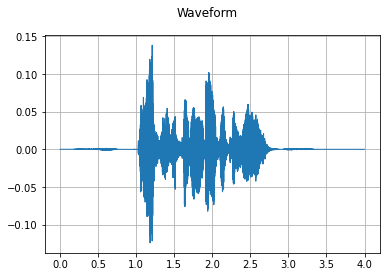

In [6]:
plot_waveform(test_sample, sample_rate=16000)

Shape: (1, 513, 126)
Dtype: torch.float32
 - Max:     81.910
 - Min:      0.000
 - Mean:     0.071
 - Std Dev:  1.332

tensor([[[3.3074e-12, 9.1810e-13, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.8111e-11, 9.2117e-13, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0960e-10, 9.3025e-13, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [4.4648e-11, 1.6333e-11, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.9293e-09, 1.6318e-11, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.4075e-09, 1.6312e-11, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])



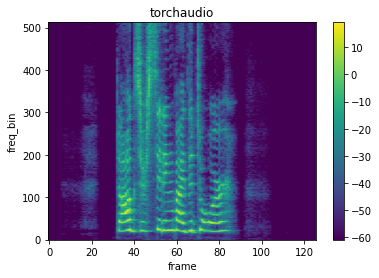

In [7]:
n_fft = 1024
win_length = None 
hop_length = 512 

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(test_sample)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')

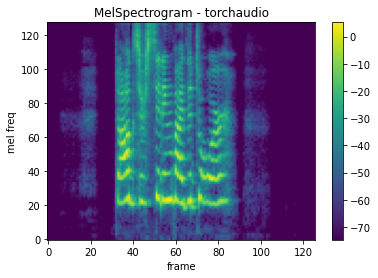

In [8]:


n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate=22050

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(test_sample)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

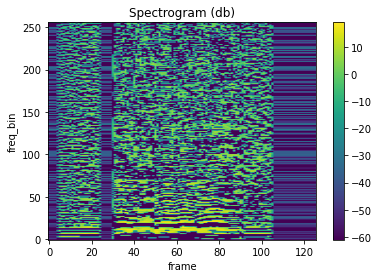

In [9]:

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(test_sample)

plot_spectrogram(mfcc[0])

In [10]:
play_audio(test_sample, 16000)

In [11]:
rav[50][0].shape

torch.Size([1, 64000])

# create training and validation sets

In [12]:

train_data, test_data = torch.utils.data.random_split(rav, [965, 415])

In [13]:
labels = sorted(list(set(r[1] for r in train_data)))
labels

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [14]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

NameError: name 'waveform' is not defined

In [15]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [16]:
word_start = "neutral"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

neutral --> tensor(5) --> neutral


In [17]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [18]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)

# Build Convolutional Neural Network Class

In [19]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [20]:
model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)

NameError: name 'transformed' is not defined

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

We will use the same optimization technique used in the paper, an Adam optimizer with weight decay set to 0.0001. At first, we will train with a learning rate of 0.01, but we will use a scheduler to decrease it to 0.001 during training after 20 epochs.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# training and Testing the Network 


In [ ]:
lost_list = []
accuracy_list = [ ]
N_test=len(test_data)


def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)
        accuracy = correct / N_test
        accuracy_list.append(accuracy)     

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
log_interval = 20
n_epoch = 50

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()


# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, label = train_data[-1]
#ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(waveform)}.")

In [ ]:
class CNN(nn.Module):

    # Constructor 
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv1d(in_channels, out_channels=out_1, kernal_size=3, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool1d(kernel_size=2)

        self.cnn2 = Conv1d(in_channels=out_1, out_channels=out_2, kernal_size=5, stride=1, padding=2)